# Process Panorama Images

In [5]:
import os, sys, torch
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/grasp-lyrl/btnk_mae.git
    sys.path.append('./btnk_mae')
else:
    sys.path.append('..')

IN_MEAN = np.array([0.485, 0.456, 0.406])
IN_STD = np.array([0.229, 0.224, 0.225])

## Load BtnkMAE Encoder and Decoder

In [7]:
from btnk_mae import BtnkMAEEncoder, BtnkMAEDecoder
from btnk_mae.utils.patchify import unpatchify


model_size = "large_gan"
act_fn = "relu"
encoder = BtnkMAEEncoder(model_size=model_size, act_fn=act_fn)
decoder = BtnkMAEDecoder(model_size=model_size)
encoder.set_img_size(512)
decoder.set_img_size(512)
checkpoint_path = "../ckpts/habitat/checkpoint-latest.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
encoder.load_state_dict(checkpoint['enc_model'], strict=False)
decoder.load_state_dict(checkpoint['dec_model'], strict=False)

/home/zhaoze/projects/btnk_mae/.venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/zhaoze/projects/btnk_mae/.venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened

<All keys matched successfully>

## Load Panorama Image

In [11]:
def load_panorama_image(img_path, square=False):
    img = Image.open(img_path).convert("RGB")
    if square:
        img = img.resize((512, 512), Image.BICUBIC)
    img = np.array(img) / 255.
    img = img - IN_MEAN
    img = img / IN_STD
    return img

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

/tmp/ipykernel_1476892/3549181712.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())


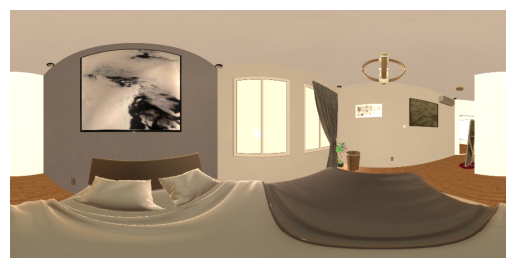

In [12]:
# load an image
img_path = f'../assets/1024x512/img_0.png'
pano_original = load_panorama_image(img_path=img_path)
show_image(torch.tensor(pano_original))

In [13]:
pano_img = load_panorama_image(img_path=img_path, square=True)  # This will be the reshaped panorama image
with torch.no_grad():
    pano_img_tensor = torch.tensor(pano_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, 224, 224)
    pano_latent = encoder(pano_img_tensor)[:, 0, :]
    pano_img_patch = decoder(pano_latent)

/tmp/ipykernel_1476892/856157172.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pano_rec = torch.clamp(pano_rec * IN_STD + IN_MEAN, 0, 1)


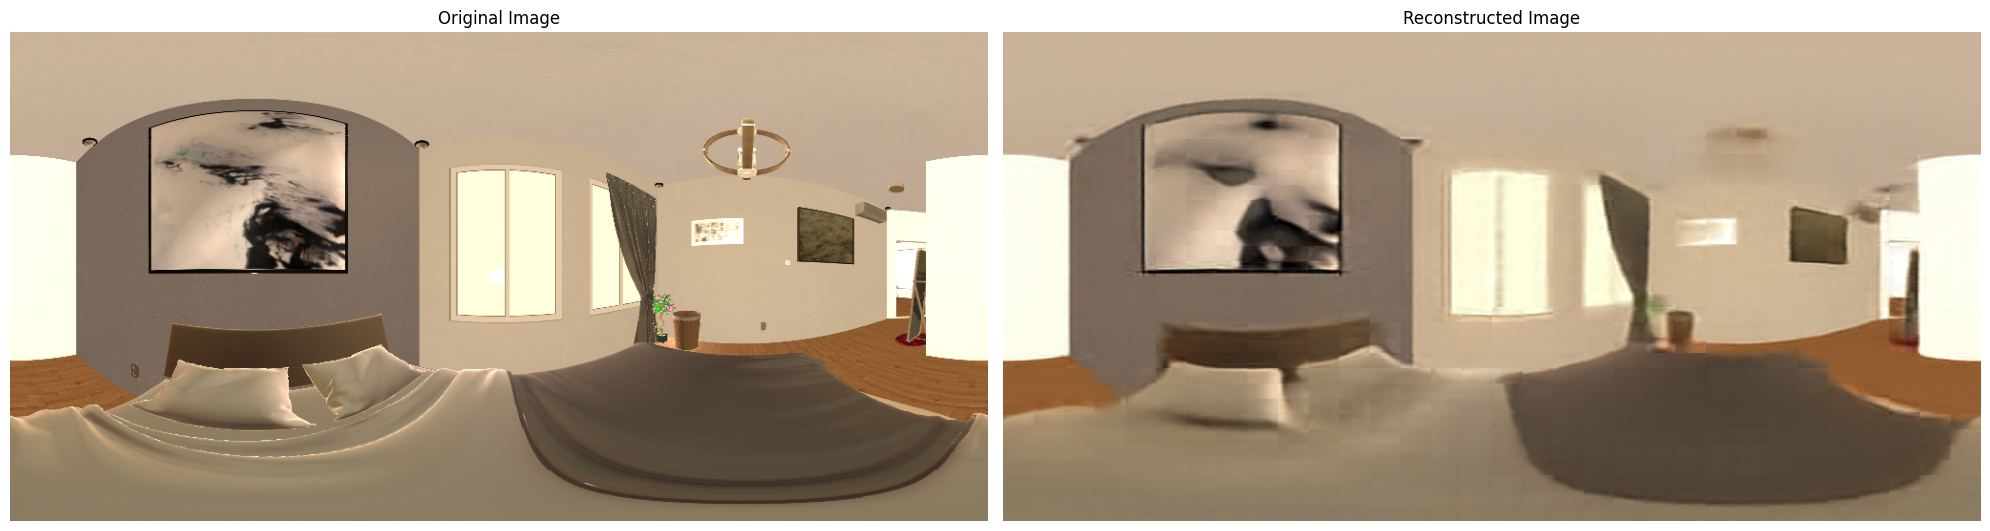

In [14]:
pano_rec = unpatchify(pano_img_patch, decoder.patch_size)[0].detach().cpu().permute(1, 2, 0)
pano_rec = torch.clamp(pano_rec * IN_STD + IN_MEAN, 0, 1)
pano_rec = Image.fromarray(np.uint8(pano_rec * 255))
pano_rec = pano_rec.resize((1024, 512), Image.BICUBIC)
pano_rec = np.array(pano_rec) / 255.

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pano_original * IN_STD + IN_MEAN)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(pano_rec)
plt.title("Reconstructed Image")
plt.axis('off')
plt.tight_layout()